In [1]:
import numpy as np

from surprise import SVD
from surprise import Dataset
from surprise.accuracy import rmse

from surprise.model_selection import train_test_split
from surprise.similarities import cosine
from Uncertain import SVDAverageEnsemble
from Uncertain.metrics import rmse as urmse
from Uncertain.metrics import misscalibration

import matplotlib.pyplot as plt

data = Dataset.load_builtin('ml-100k')
train, test = train_test_split(data, test_size=0.1, random_state=0)
nu = train.n_users
ni = train.n_items

In [18]:
ensemble = 20
epochs = 20
factors = 100

models = []
RMSE = np.empty((ensemble))
preds = np.empty((ensemble, len(test)))

for i in range(ensemble):
    models.append(SVD(random_state=i, n_epochs=epochs, n_factors=factors).fit(train))
    preds_ = models[i].test(test)
    RMSE[i] = rmse(preds_, verbose=False)
    preds[i] = [i.est for i in preds_]
print('Min RMSE =', round(np.min(RMSE), 4), '; Max RMSE =', round(np.max(RMSE), 4))

Min RMSE = 0.9403 ; Max RMSE = 0.9478


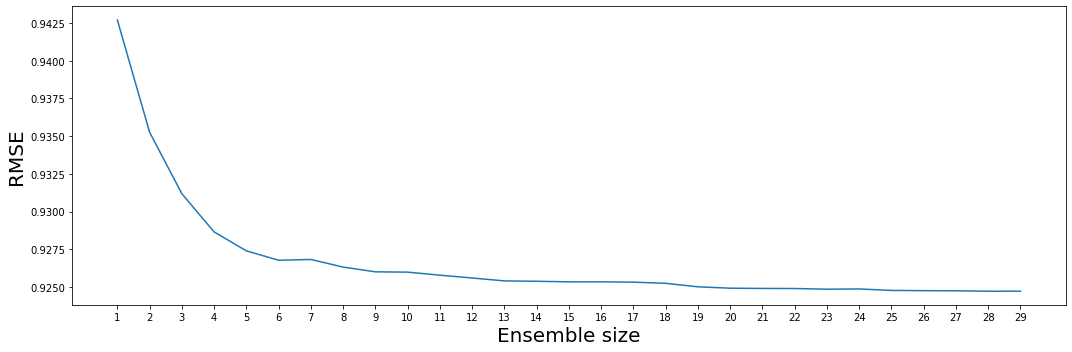

In [19]:
eRMSE = np.empty((ensemble))
for i in range(ensemble):
    model = SVDAverageEnsemble()
    model.pass_fitted(models[:i+1])
    upreds = model.test(test)
    eRMSE[i] = urmse(upreds, verbose=False)

f, ax = plt.subplots(figsize=(15,5))
ax.plot(range(1, ensemble+1), eRMSE)
ax.set_xticks(range(1, ensemble+1))
ax.set_xlabel('Ensemble size', Fontsize=20)
ax.set_ylabel('RMSE', Fontsize=20)
f.tight_layout()
f.savefig('seed/RMSE vs Size.pdf')

In [20]:
model.predict('1', '1', verbose=True)
model.predict('1', '1000', verbose=True)
print('Full ensemble RMSE:', eRMSE[-1])

user: 1          item: 1          r_ui = None   est = 3.81   unc = 0.27   {'was_impossible': False}
user: 1          item: 1000       r_ui = None   est = 3.09   unc = 0.17   {'was_impossible': False}
Full ensemble RMSE: 0.924722177500653


array([[ 1.        ,  0.09698922,  0.27443566],
       [ 0.09698922,  1.        , -0.02536972],
       [ 0.27443566, -0.02536972,  1.        ]])

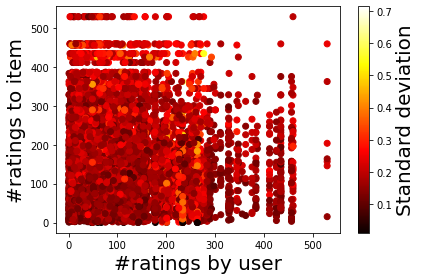

In [21]:
uids = np.unique([i.uid for i in upreds])
iids = np.unique([i.iid for i in upreds])

nu = [len(train.ir[train.to_inner_uid(uid)]) for uid in uids]
ni = np.empty((len(iids)))
for i, iid in enumerate(iids):
    try:
        ni[i] = len(train.ir[train.to_inner_iid(iid)])
    except:
        ni[i] = 0
        
pred_n = np.empty((len(upreds), 3))
for i in range(len(pred_n)):
    pred_n[i] = [upreds[i].unc, nu[np.where(upreds[i].uid == uids)[0][0]], ni[np.where(upreds[i].iid == iids)[0][0]]]
pred_n = np.delete(pred_n, (277, 412), axis=0)

f, ax = plt.subplots()
sp = ax.scatter(pred_n[:, 1], pred_n[:, 2], c=pred_n[:, 0], cmap='hot')
f.colorbar(sp).set_label(label='Standard deviation', size=20)
ax.set_xlabel('#ratings by user', Fontsize=20)
ax.set_ylabel('#ratings to item', Fontsize=20)
f.tight_layout()
f.savefig('seed/SD distribution.pdf')
np.corrcoef(pred_n.T)

array([[ 1.        , -0.23812415, -0.03807951],
       [-0.23812415,  1.        ,  0.14418257],
       [-0.03807951,  0.14418257,  1.        ]])

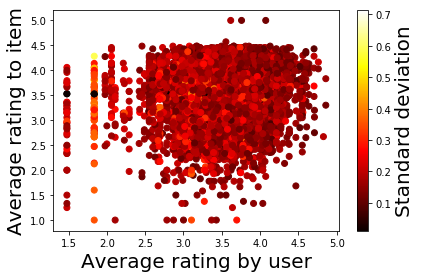

In [22]:
avgu = [np.mean([t[1] for t in train.ur[train.to_inner_uid(uid)]]) for uid in uids]
avgi = np.empty((len(iids)))
for i, iid in enumerate(iids):
    try:
        avgi[i] = np.mean([t[1] for t in train.ir[train.to_inner_iid(iid)]])
    except:
        avgi[i] = train.global_mean

pred_n = np.empty((len(upreds), 3))
for i in range(len(pred_n)):
    pred_n[i] = [upreds[i].unc, avgu[np.where(upreds[i].uid == uids)[0][0]], avgi[np.where(upreds[i].iid == iids)[0][0]]]
pred_n = np.delete(pred_n, (277, 412), axis=0)

f, ax = plt.subplots()
sp = ax.scatter(pred_n[:, 1], pred_n[:, 2], c=pred_n[:, 0], cmap='hot')
f.colorbar(sp).set_label(label='Standard deviation', size=20)
ax.set_xlabel('Average rating by user', Fontsize=20)
ax.set_ylabel('Average rating to item', Fontsize=20)
f.tight_layout()
f.savefig('seed/SD distribution2.pdf')

np.corrcoef(pred_n.T)

/home/vcoscrato/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

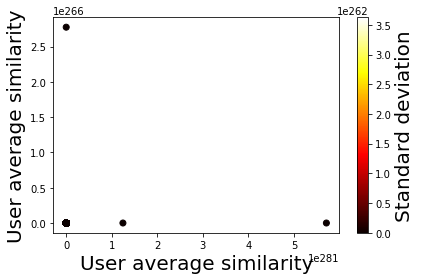

In [23]:
simu = models[0].compute_similarities().mean(axis=0)
models[1].sim_options['user_based'] = False
simi = models[1].compute_similarities().mean(axis=0)

pred_n = np.empty((len(upreds), 3))
for i in range(len(pred_n)):
    try:
        pred_n[i] = [upreds[i].unc, simu[train.to_inner_uid(upreds[i].uid)], simi[train.to_inner_iid(upreds[i].iid)]]
    except:
        pass
pred_n = np.delete(pred_n, (277, 412), axis=0)

f, ax = plt.subplots()
sp = ax.scatter(pred_n[:, 1], pred_n[:, 2], c=pred_n[:, 0], cmap='hot')
f.colorbar(sp).set_label(label='Standard deviation', size=20)
ax.set_xlabel('User average similarity', Fontsize=20)
ax.set_ylabel('User average similarity', Fontsize=20)
f.tight_layout()
f.savefig('seed/SD distribution3.pdf')

np.corrcoef(pred_n.T)

In [24]:
model.rank('1')
# Change the rank to the UncertainRank format and then calculate KendallW for the aggregated ones - For the non aggregated create a printing function also

[['169', (4.867204871222005, 0.1688789403849105)],
 ['114', (4.736180521939902, 0.18377862244885296)],
 ['12', (4.704195436956358, 0.16884820995918035)],
 ['127', (4.69539523394579, 0.23750554257479767)],
 ['168', (4.66461631373414, 0.24525475546763437)],
 ['48', (4.630718458277884, 0.18741980319606857)],
 ['178', (4.630065536541651, 0.13436747824435802)],
 ['285', (4.614983188083121, 0.23469122761196706)],
 ['64', (4.576320006831922, 0.1978234502606085)],
 ['511', (4.54023754711388, 0.1976483941542519)]]

In [25]:
from Uncertain.metrics import urmse

In [26]:
urmse(upreds, verbose=True)

RMSE: 0.4087


0.40872467167212795

In [27]:
err = [abs(u.est - u.r_ui) for u in upreds]
unc = [u.unc for u in upreds]
np.corrcoef(err, unc)[0, 1]

0.1468792414585173

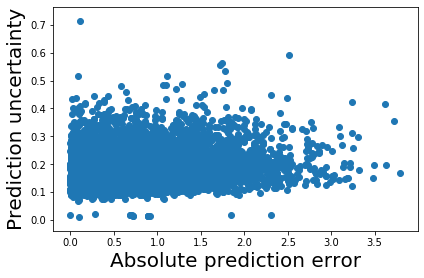

In [28]:
f, ax = plt.subplots()
sp = ax.scatter(err, unc)
ax.set_xlabel('Absolute prediction error', Fontsize=20)
ax.set_ylabel('Prediction uncertainty', Fontsize=20)
f.tight_layout()
f.savefig('seed/correlation.pdf')

In [29]:
score, hot, err, sd, p, t_p, conf = misscalibration(n=ensemble, predictions=upreds, verbose=False)
print(score)

0.4649729166666671


In [30]:
def build_intervals(predictions, bins=20, step=0.1, verbose=True):
    predictions = [predictions[i] for i in np.argsort([p.unc for p in predictions])]
    n = len(predictions)
    w = np.zeros((20))
    err = np.zeros((20))
    for b in range(bins):
        predictions_ = predictions[int((b/bins)*n):int(((b+1)/bins)*n)]
        p = 0
        while(p < 0.95):
            w[b] += 0.01
            inside = 0
            for p in predictions_:
                err[b] += abs(p.est - p.r_ui)
                if abs(p.est - p.r_ui) < w[b]:
                    inside += 1
            p = inside/len(predictions_)
    return w, err

In [31]:
a = build_intervals(upreds)

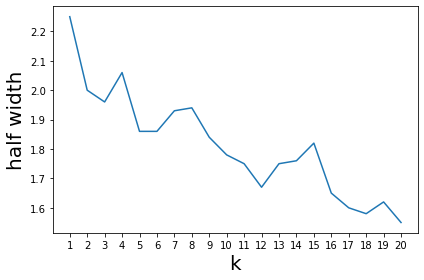

In [32]:
f, ax = plt.subplots()
ax.plot(range(1, 21), a[0][::-1])
ax.set_xlabel('k', Fontsize=20)
ax.set_ylabel('half width', Fontsize=20)
ax.set_xticks(range(1, 21))
f.tight_layout()
f.savefig('seed/mimic.pdf')